# Duration of Response Analysis

In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import math
from lifelines.plotting import rmst_plot
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
df = pd.read_excel('Survival.xlsx')

In [3]:
END_OF_STUDY=6    # Study is finished at month 6.

In [4]:
df

,PatientID,Responded,Response_time,Progressed,Progress_time
0,1,1,2.0,1,8
1,2,1,3.0,1,5
2,3,1,2.0,0,4
3,4,0,NaN,0,3
4,5,0,NaN,1,5
5,6,0,NaN,1,10


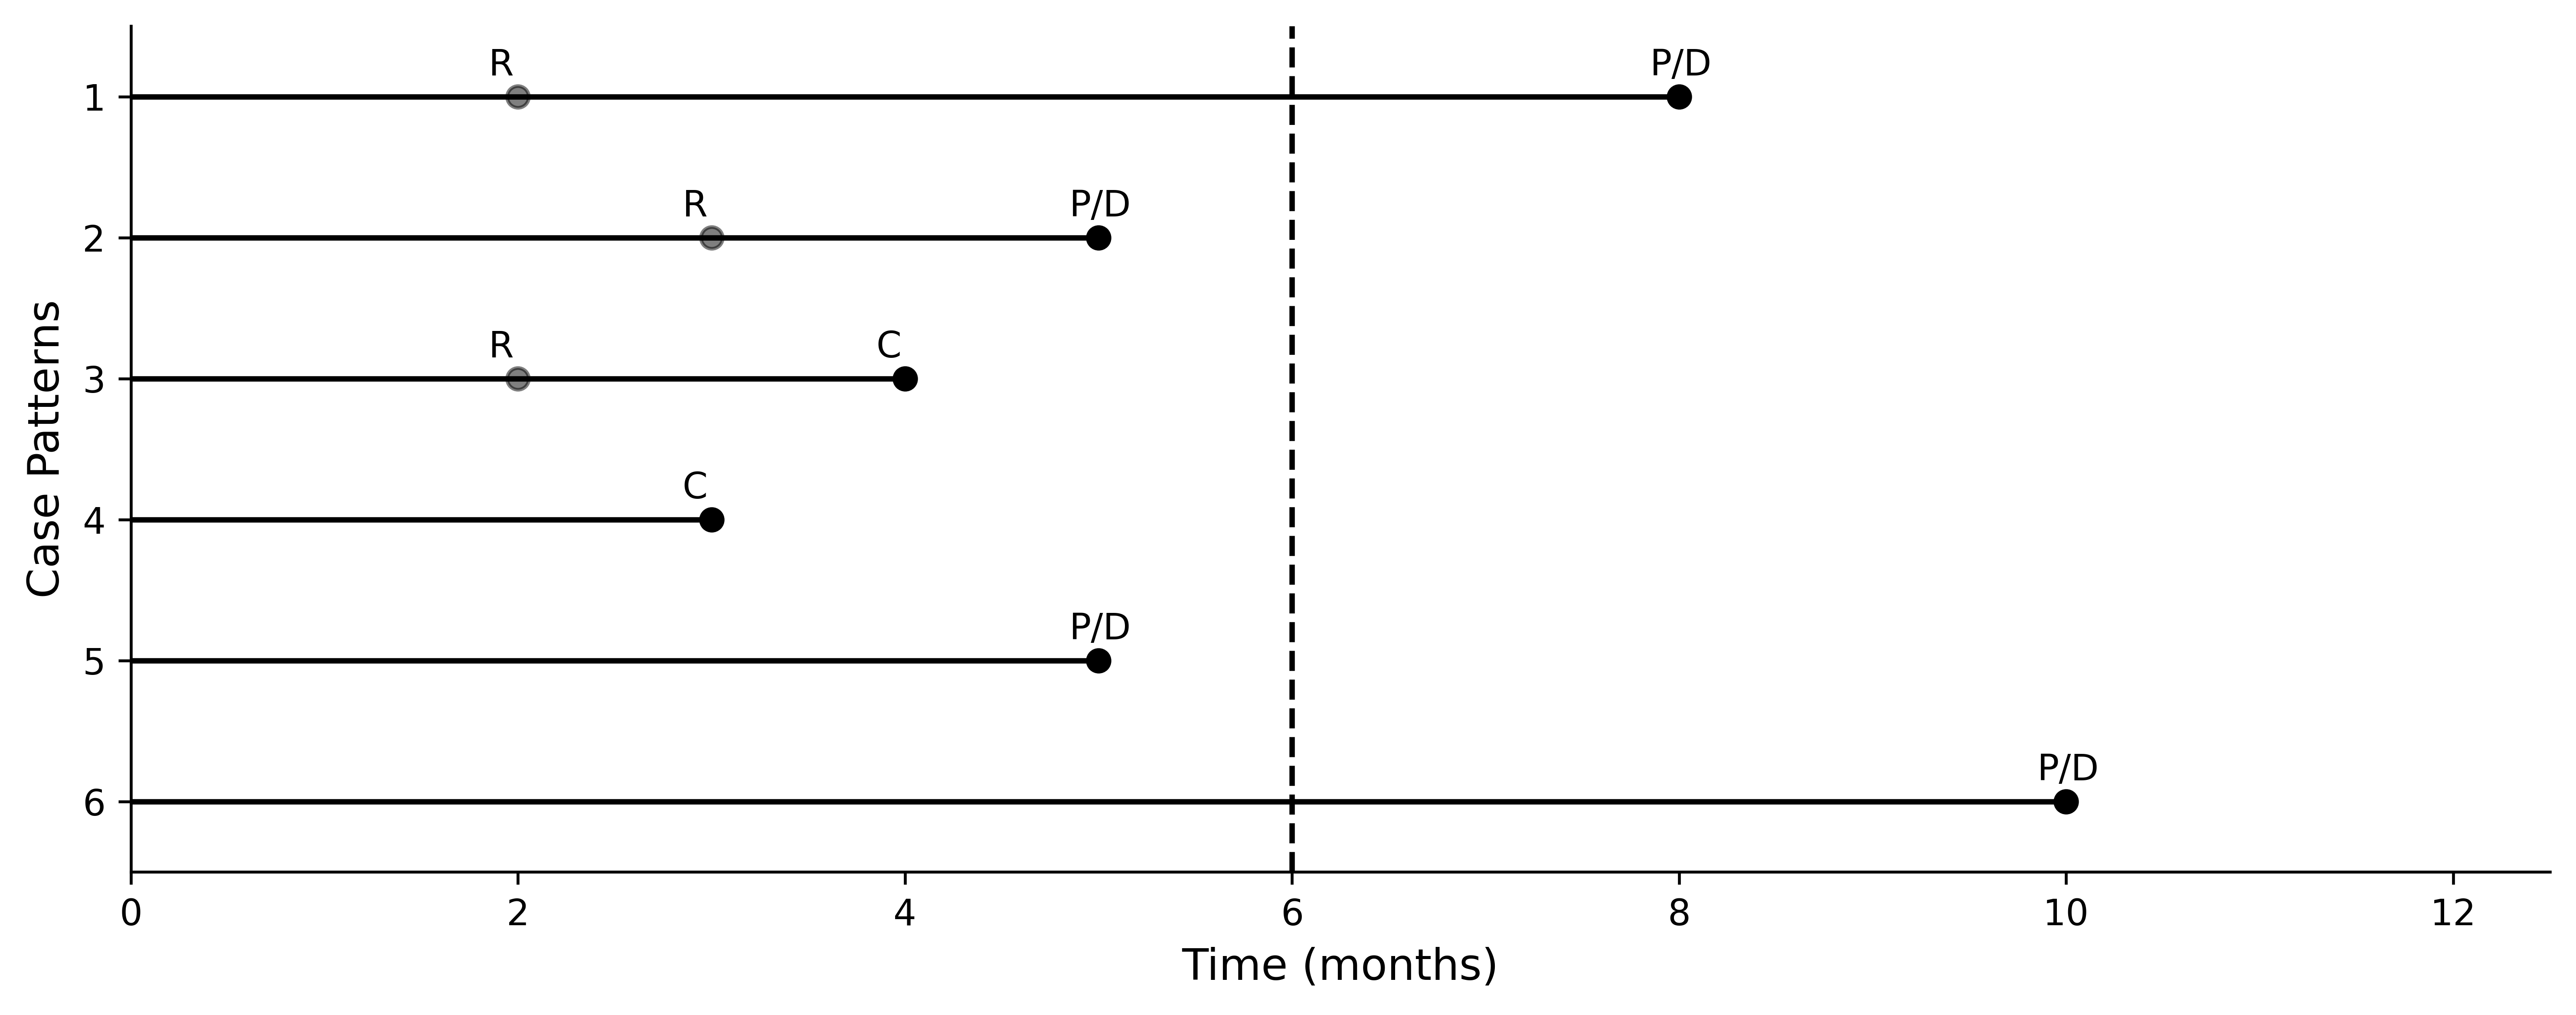

In [28]:
plt.figure(figsize=(10,4), dpi=600)

patients = np.array(df['PatientID'])

plt.hlines(patients[df.Progressed.values == 0], 0, df[df.Progressed.values == 0].Progress_time, color='k', linestyles='solid')
plt.hlines(patients[df.Progressed.values == 1], 0, df[df.Progressed.values == 1].Progress_time, color='k', linestyles='solid');

plt.scatter(df[df.Progressed.values == 1].Progress_time, patients[df.Progressed.values == 1], color='k')
plt.scatter(df[df.Progressed.values == 0].Progress_time, patients[df.Progressed.values == 0], color='k')
plt.scatter(df[df.Responded.values == 1].Response_time, patients[df.Responded.values == 1], alpha=0.5, color='k')



# plt.legend(loc = 'lower right')
plt.xlabel('Time (months)' , fontsize=12)
plt.ylabel('Case Patterns' , fontsize=12)


plt.xlim([0, 12.5])
plt.ylim(max(df['PatientID'])+0.5, 0.5)

plt.grid(False)
plt.axvline(x=6, color='black', linestyle='--')

for x, y in zip(df[df.Progressed.values == 1].Progress_time, patients[df.Progressed.values == 1]):
    plt.annotate('P/D', (x-0.15,y-0.15))

for x, y in zip(df[df.Progressed.values == 0].Progress_time, patients[df.Progressed.values == 0]):
    plt.annotate('C', (x-0.15,y-0.15))
    
for x, y in zip(df[df.Responded.values == 1].Response_time, patients[df.Responded.values == 1]):
    plt.annotate('R', (x-0.15,y-0.15))   
    
    
plt.tight_layout()

In [6]:
kmf1 = KaplanMeierFitter()
df_melt1 = pd.melt(df, id_vars=['PatientID','Progressed'], value_vars=['Progress_time'])
df_melt1

,PatientID,Progressed,variable,value
0,1,1,Progress_time,8
1,2,1,Progress_time,5
2,3,0,Progress_time,4
3,4,0,Progress_time,3
4,5,1,Progress_time,5
5,6,1,Progress_time,10


In [7]:
months, PD_free_probability =[],[]

for i in range(1,7):
    months.append(i)
    kmf1.fit(df_melt1['value'], df_melt1['Progressed'], label='P/D')
       
    PD_free_probability.append(kmf1.predict(i).round(2))
        
df_PD_free_probability = pd.DataFrame(np.column_stack([months, PD_free_probability]), columns=['Month','PD_free_probability'])
    
df_PD_free_probability['Month']=df_PD_free_probability['Month'].astype(int)

In [9]:
df['PDR_times']= df[['Response_time','Progress_time']].min(axis=1)

In [10]:
df['PDR']=np.where((df['Responded']==0) & (df['Progressed']==0) |(df['PDR_times']>END_OF_STUDY) , 0, 1)

In [12]:
df_melt2 = pd.melt(df, id_vars=['PatientID','PDR'], value_vars=['PDR_times'])

In [13]:
kmf2 = KaplanMeierFitter()
months, PDR_free_probability =[],[]


for i in range(1,7):
    
        months.append(i)
        kmf2.fit(df_melt2['value'], df_melt2['PDR'], label='P/D/R')
       
        PDR_free_probability.append(kmf2.predict(i).round(2))


In [14]:
df_PDR_free_probability = pd.DataFrame(np.column_stack([months, PDR_free_probability]), columns=['Month', 'PDR_free_probability'])
df_PDR_free_probability['Month']=df_PDR_free_probability['Month'].astype(int)


# Probability of Being in Response (BPIR)

In [18]:
df_PBIR = df_PD_free_probability.merge(df_PDR_free_probability, on="Month")
df_PBIR['PBIR'] = df_PBIR['PD_free_probability'] - df_PBIR['PDR_free_probability']

In [34]:
df_PBIR.transpose()[1:].round(2)

,0,1,2,3,4,5
PD_free_probability,1.0,1.00,1.0,1.0,0.50,0.50
PDR_free_probability,1.0,0.67,0.5,0.5,0.25,0.25
PBIR,0.0,0.33,0.5,0.5,0.25,0.25


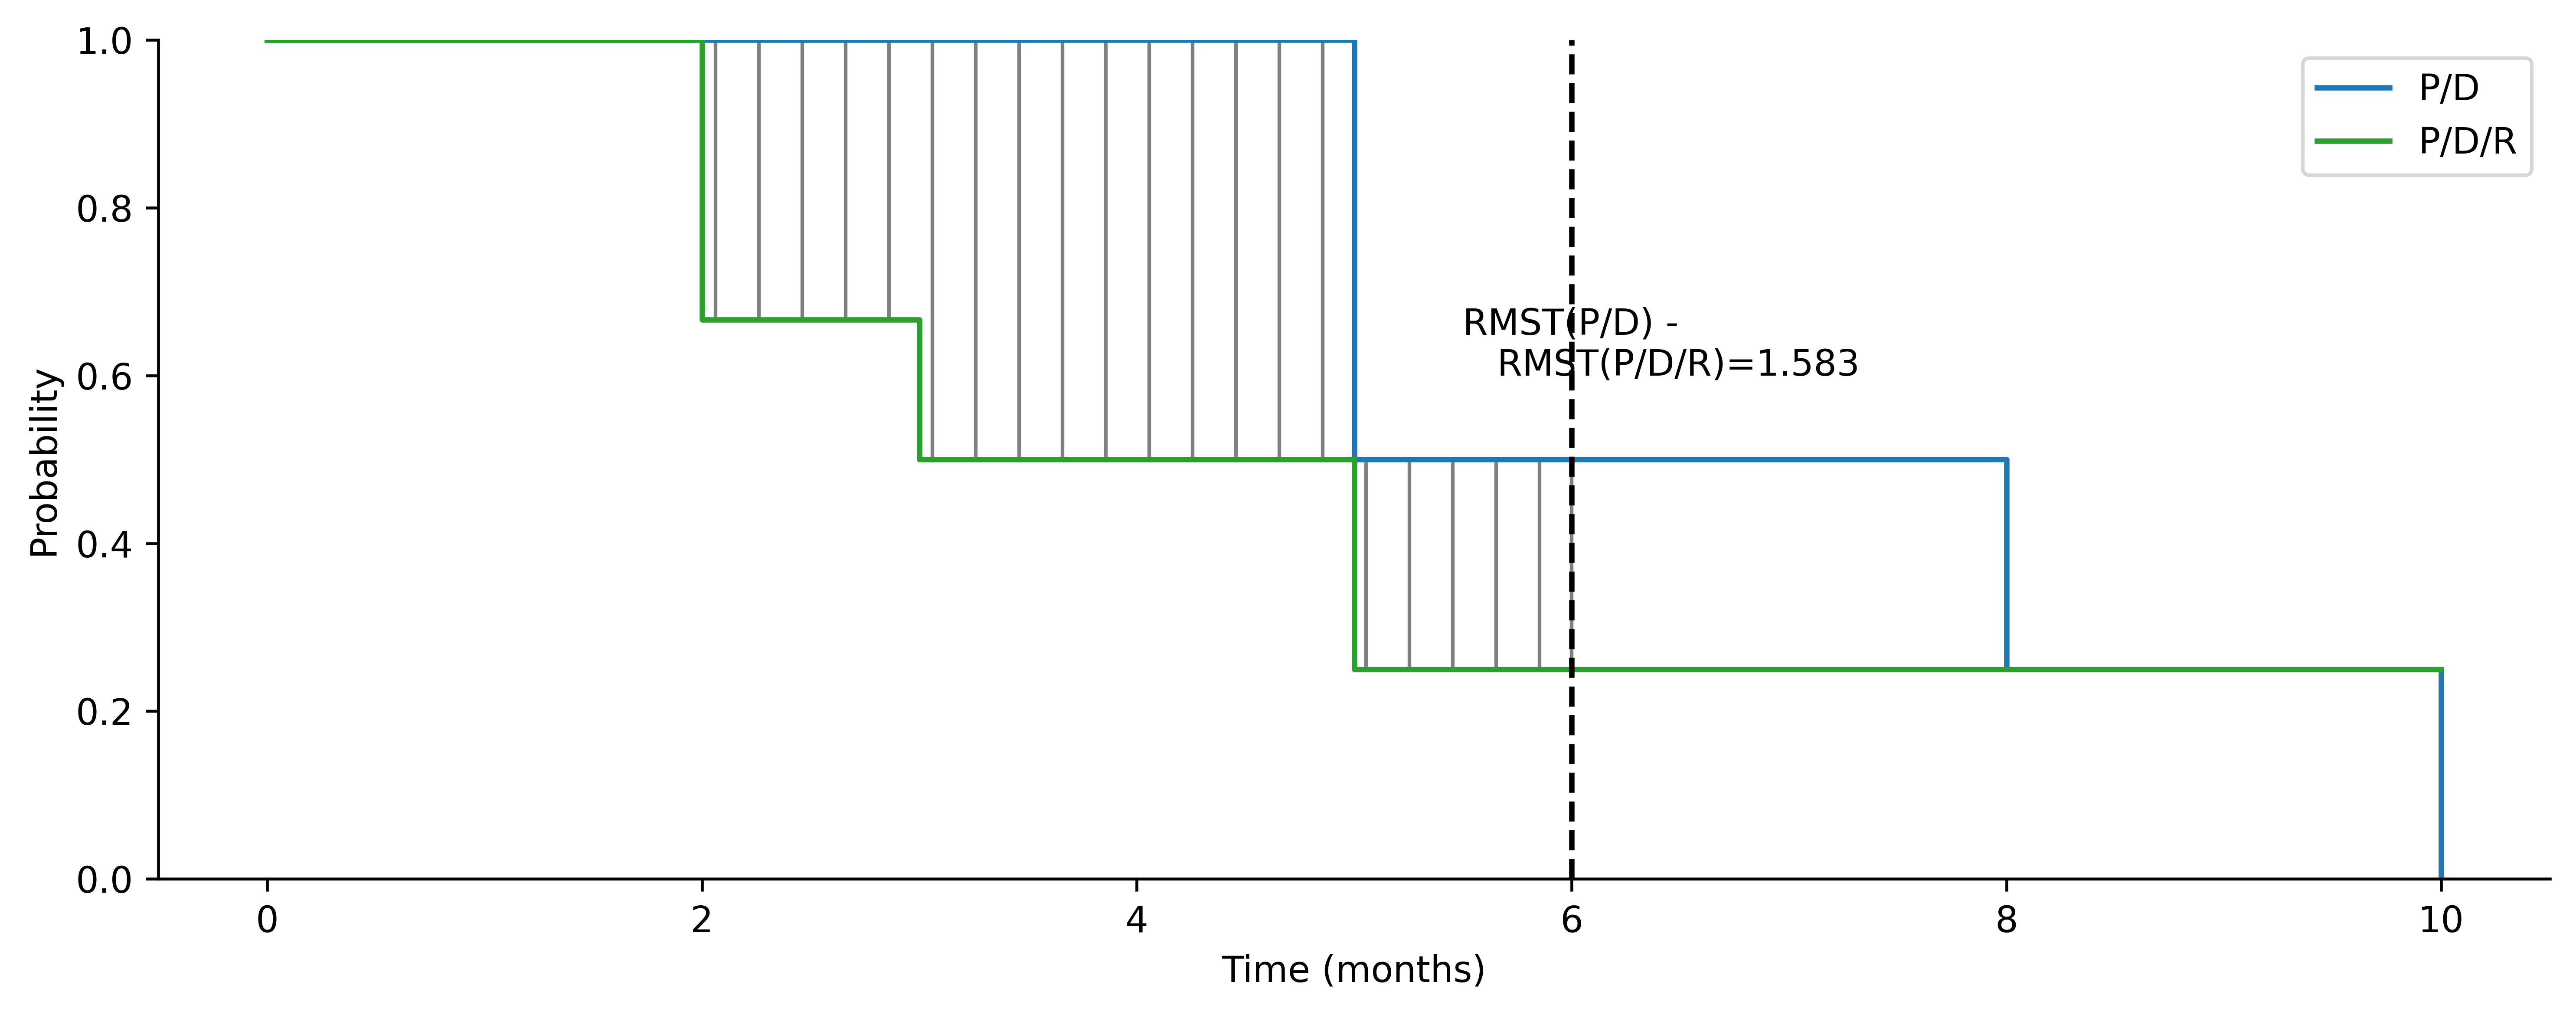

In [32]:
plt.figure(figsize=(10,4), dpi=600)

rmst_plot(kmf1,kmf2, t=6, text_position=(5.5,0.6))
plt.xlabel('Time (months)')
plt.ylabel('Probability')

plt.tight_layout()

## Reference:
Huang B, Tian L, McCaw ZR, Luo X, Talukder E, Rothenberg M, Xie W, Choueiri TK, Kim DH, Wei LJ. Analysis of Response Data for Assessing Treatment Effects in Comparative Clinical Studies. Ann Intern Med. 2020 Sep 1;173(5):368-374. doi: 10.7326/M20-0104. Epub 2020 Jul 7. PMID: 32628533; PMCID: PMC7773521.